In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import joblib

import re
import nltk
from nltk.corpus import stopwords
import nltk as nlp
from sklearn.feature_extraction.text import CountVectorizer


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from keras.layers import LSTM
from tensorflow.keras.layers import Embedding,  Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


In [2]:
df = pd.read_csv('fake_job_postings.csv', encoding= "UTF-8")
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [4]:
df.company_profile.head()

0    We're Food52, and we've created a groundbreaki...
1    90 Seconds, the worlds Cloud Video Production ...
2    Valor Services provides Workforce Solutions th...
3    Our passion for improving quality of life thro...
4    SpotSource Solutions LLC is a Global Human Cap...
Name: company_profile, dtype: object

In [5]:
df.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [6]:
df.fraudulent.value_counts()

fraudulent
0    17014
1      866
Name: count, dtype: int64

In [7]:
df.telecommuting.value_counts()


telecommuting
0    17113
1      767
Name: count, dtype: int64

In [8]:
type(df.title[0])
df.title = df.title.str.strip()
df.title.value_counts()


title
English Teacher Abroad                                         406
Customer Service Associate                                     198
Graduates: English Teacher Abroad (Conversational)             144
Customer Service Associate - Part Time                          91
Software Engineer                                               90
                                                              ... 
Sales Executive - Office Equipment                               1
QA/QC Leader - Cured Meats Co - Chicagoland                      1
Application Developer/SQL Server                                 1
Training Assistant                                               1
Project Cost Control Staff Engineer - Cost Control Exp - TX      1
Name: count, Length: 10915, dtype: int64

In [9]:
df.location.value_counts()


location
GB, LND, London          718
US, NY, New York         658
US, CA, San Francisco    472
GR, I, Athens            464
US, ,                    339
                        ... 
GB, SFK, Leiston           1
GB, LND, Hammersmith       1
US, WA, Seattle            1
BE                         1
GB, WSX, Chichester        1
Name: count, Length: 3105, dtype: int64

In [10]:
df.department.value_counts()


department
Sales                                          551
Engineering                                    487
Marketing                                      401
Operations                                     270
IT                                             225
                                              ... 
Commercial Management / Contract Management      1
Exec                                             1
Marcomm                                          1
CRM                                              1
Hospitality                                      1
Name: count, Length: 1337, dtype: int64

In [11]:
print(df.salary_range.value_counts())


salary_range
0-0            142
40000-50000     66
30000-40000     55
25000-30000     37
45000-67000     37
              ... 
15-25            1
60-75            1
27500-36000      1
20-22            1
3700-3800        1
Name: count, Length: 874, dtype: int64


In [12]:
df.employment_type.value_counts()


employment_type
Full-time    11620
Contract      1524
Part-time      797
Temporary      241
Other          227
Name: count, dtype: int64

In [13]:
df.required_education.value_counts()


required_education
Bachelor's Degree                    5145
High School or equivalent            2080
Unspecified                          1397
Master's Degree                       416
Associate Degree                      274
Certification                         170
Some College Coursework Completed     102
Professional                           74
Vocational                             49
Some High School Coursework            27
Doctorate                              26
Vocational - HS Diploma                 9
Vocational - Degree                     6
Name: count, dtype: int64

In [14]:
df.industry.value_counts()


industry
Information Technology and Services    1734
Computer Software                      1376
Internet                               1062
Marketing and Advertising               828
Education Management                    822
                                       ... 
Shipbuilding                              1
Sporting Goods                            1
Museums and Institutions                  1
Wine and Spirits                          1
Ranching                                  1
Name: count, Length: 131, dtype: int64

In [15]:
df.function.value_counts()

function
Information Technology    1749
Sales                     1468
Engineering               1348
Customer Service          1229
Marketing                  830
Administrative             630
Design                     340
Health Care Provider       338
Other                      325
Education                  325
Management                 317
Business Development       228
Accounting/Auditing        212
Human Resources            205
Project Management         183
Finance                    172
Consulting                 144
Writing/Editing            132
Art/Creative               132
Production                 116
Product Management         114
Quality Assurance          111
Advertising                 90
Business Analyst            84
Data Analyst                82
Public Relations            76
Manufacturing               74
General Business            68
Research                    50
Legal                       47
Strategy/Planning           46
Training                    38

C:\Users\USER\AppData\Local\Temp\ipykernel_19180\1598691197.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sb.countplot(x='fraudulent', data=df, palette=["Orange", "red"])


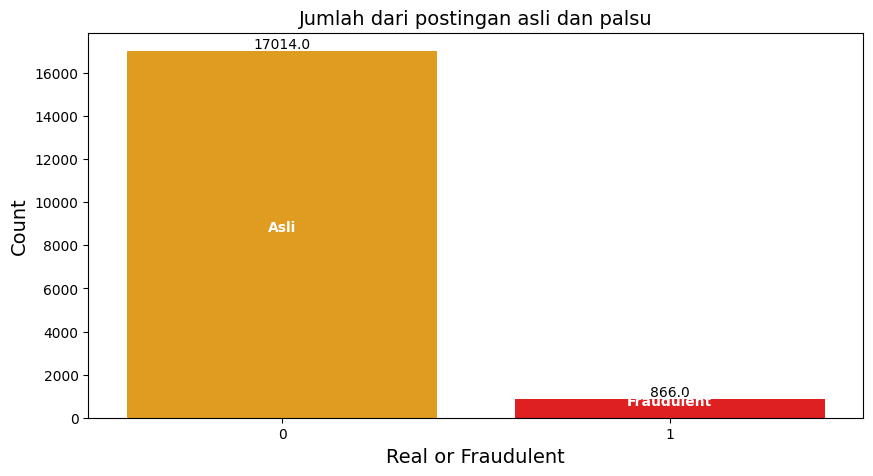

In [16]:
labels = ['Asli', 'Fraudulent']
plt.figure(figsize=(10, 5))
ax = sb.countplot(x='fraudulent', data=df, palette=["Orange", "red"])
total = float(len(df))
if ax.patches:
    for p, label in zip(ax.patches, labels):
        height = p.get_height()
        percentage = '{:.1f}%'.format((height / total)*100)
        ax.text(p.get_x() + p.get_width() / 2, height + 0.1, height, ha='center', va='bottom')
        ax.text(p.get_x() + p.get_width() / 2, height / 2, label, ha='center', va='bottom', color='white', weight='bold')
plt.title("Jumlah dari postingan asli dan palsu", fontdict={"fontsize": 14})
plt.ylabel("Count", fontdict={"fontsize": 14})
plt.xlabel('Real or Fraudulent', fontdict={"fontsize": 14})

# plt.clf()
# fraud_counts = df['fraudulent'].value_counts()
# plt.figure(figsize=(8, 8))
# plt.pie(fraud_counts, labels =labels, autopct='%1.1f%%', colors=['orange' ,'red'], startangle=140)
# plt.title('asdad')
# plt.axis('equal')

plt.show()

In [17]:
title = df.title.value_counts()[:5]
title

title
English Teacher Abroad                                406
Customer Service Associate                            198
Graduates: English Teacher Abroad (Conversational)    144
Customer Service Associate - Part Time                 91
Software Engineer                                      90
Name: count, dtype: int64

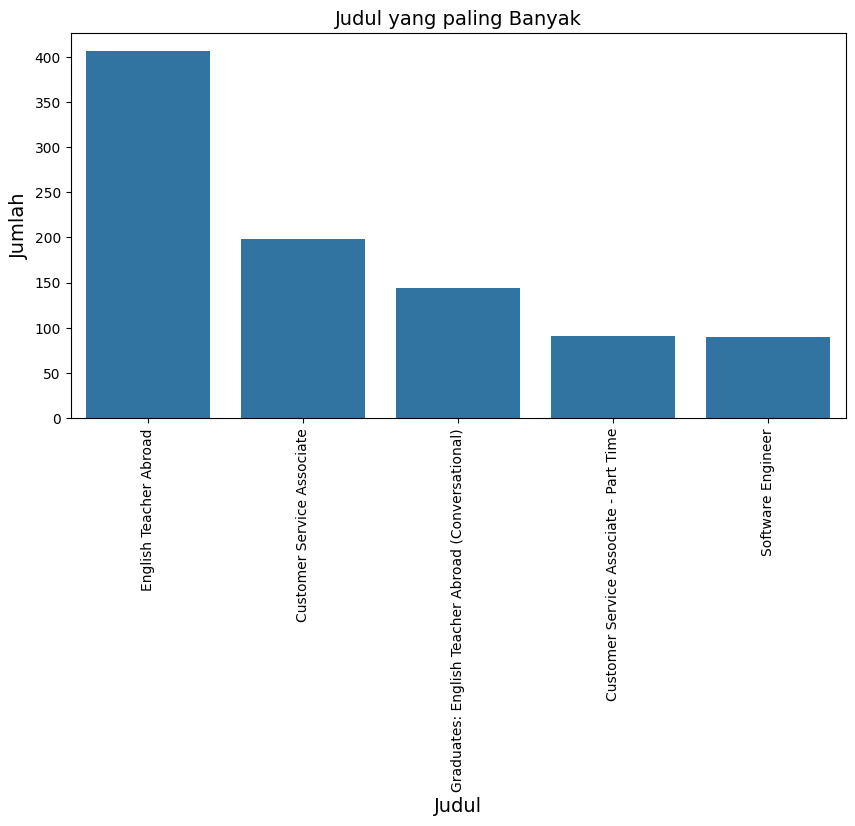

In [18]:
plt.figure(figsize = (10,5))
sb.barplot(x = title.index, y = title )
plt.title("Judul yang paling Banyak", fontdict = {"fontsize" : 14})
plt.xlabel("Judul", fontdict = {"fontsize" : 14})
plt.ylabel("Jumlah", fontdict = {"fontsize" : 14})
plt.xticks(rotation=90);

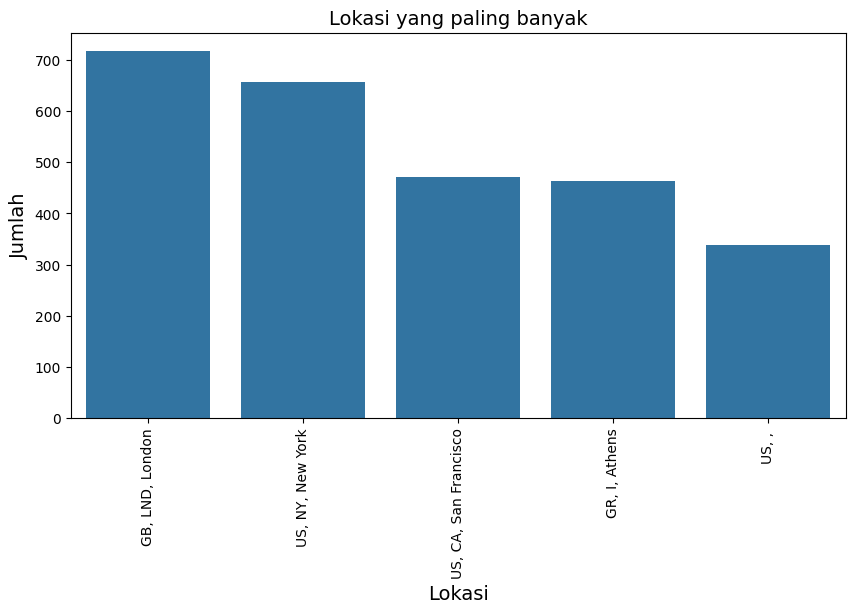

In [19]:
location_of_fraudulent = df.location[df.fraudulent == 1].value_counts()[:5]
location = df.location.value_counts()[:5]

plt.figure(figsize = (10,5))
sb.barplot(x = location.index, y = location, )
plt.title("Lokasi yang paling banyak", fontdict = {"fontsize" : 14})
plt.xlabel("Lokasi", fontdict = {"fontsize" : 14})
plt.ylabel("Jumlah", fontdict = {"fontsize" : 14})
plt.xticks(rotation=90);

has_company_logo
0    583
1    283
Name: count, dtype: int64


C:\Users\USER\AppData\Local\Temp\ipykernel_19180\3403520002.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x = has_company_logo1.index, y = has_company_logo1, palette = palette)


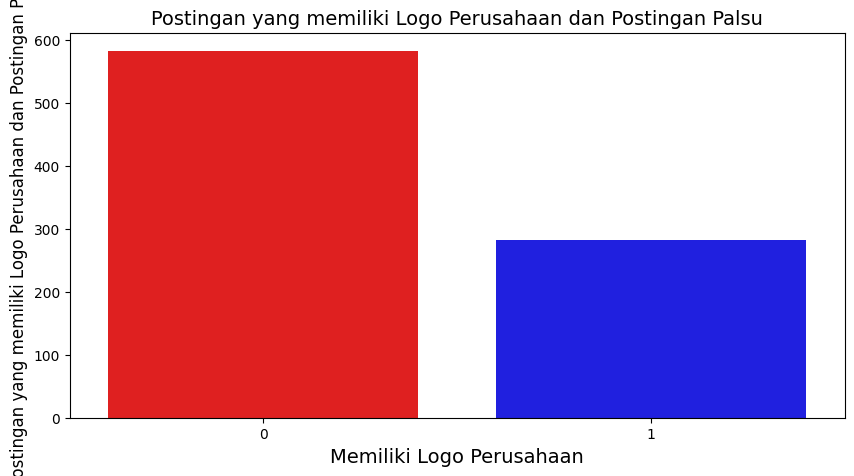

In [20]:
has_company_logo1 = df.has_company_logo[df.fraudulent == 1]
has_company_logo1 = has_company_logo1.value_counts()
print(has_company_logo1)

palette = ["red", "blue" ]
plt.figure(figsize = (10,5))
sb.barplot(x = has_company_logo1.index, y = has_company_logo1, palette = palette)
plt.title("Postingan yang memiliki Logo Perusahaan dan Postingan Palsu", fontdict = {"fontsize" : 14})
plt.xlabel("Memiliki Logo Perusahaan", fontdict = {"fontsize" : 14})
plt.ylabel("Postingan yang memiliki Logo Perusahaan dan Postingan Palsu", fontdict = {"fontsize" : 12})
plt.xticks(rotation=0);

In [21]:
df.has_questions.value_counts()

has_questions
0    9088
1    8792
Name: count, dtype: int64

In [22]:
has_questions1 = df.has_questions[df.fraudulent == 1].value_counts()
print(has_questions1)

has_questions
0    616
1    250
Name: count, dtype: int64


C:\Users\USER\AppData\Local\Temp\ipykernel_19180\3358235863.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x = has_questions1.index, y = has_questions1, palette = palette)


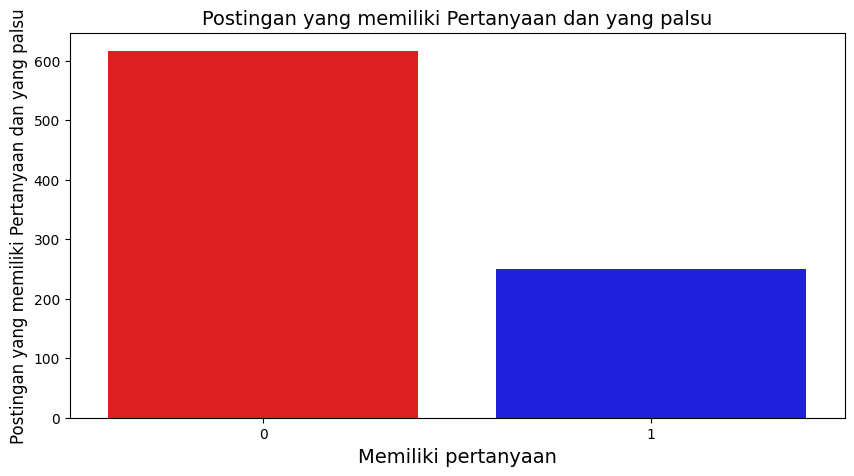

In [23]:
plt.figure(figsize = (10,5))
sb.barplot(x = has_questions1.index, y = has_questions1, palette = palette)
plt.title("Postingan yang memiliki Pertanyaan dan yang palsu", fontdict = {"fontsize" : 14})
plt.xlabel("Memiliki pertanyaan", fontdict = {"fontsize" : 14})
plt.ylabel("Postingan yang memiliki Pertanyaan dan yang palsu", fontdict = {"fontsize" : 12})
plt.xticks(rotation=0);

In [24]:
employment_type = df.employment_type.value_counts()
employment_type



employment_type
Full-time    11620
Contract      1524
Part-time      797
Temporary      241
Other          227
Name: count, dtype: int64

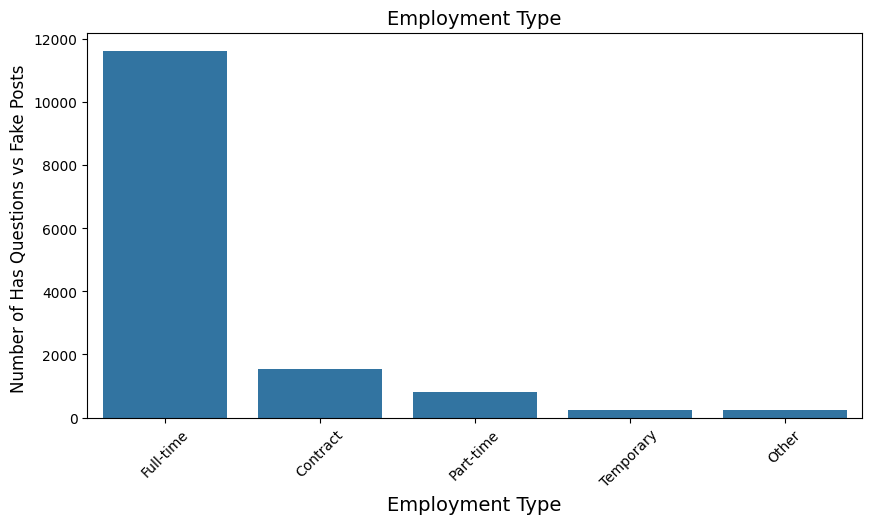

In [25]:
plt.figure(figsize = (10,5))
sb.barplot(x = employment_type.index, y = employment_type)
plt.title("Employment Type", fontdict = {"fontsize" : 14})
plt.xlabel("Employment Type", fontdict = {"fontsize" : 14})
plt.ylabel("Number of Has Questions vs Fake Posts ", fontdict = {"fontsize" : 12})
plt.xticks(rotation = 45);

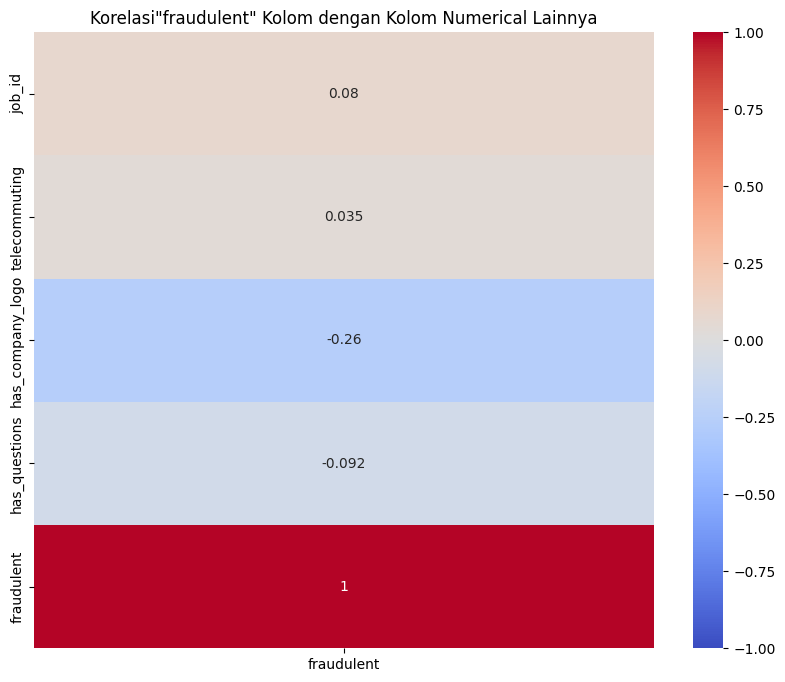

In [26]:
numeric_df = df.select_dtypes(include='number')
corr = numeric_df.corr()['fraudulent'] 

plt.figure(figsize=(10, 8))
sb.heatmap(corr.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Korelasi"fraudulent" Kolom dengan Kolom Numerical Lainnya')
plt.show()

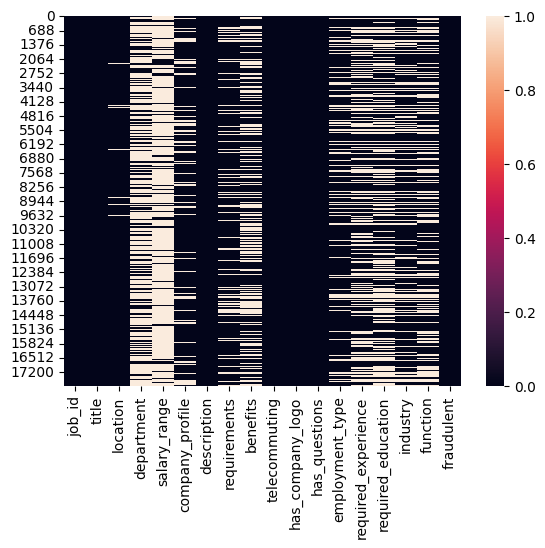

In [27]:
sb.heatmap(df.isnull());


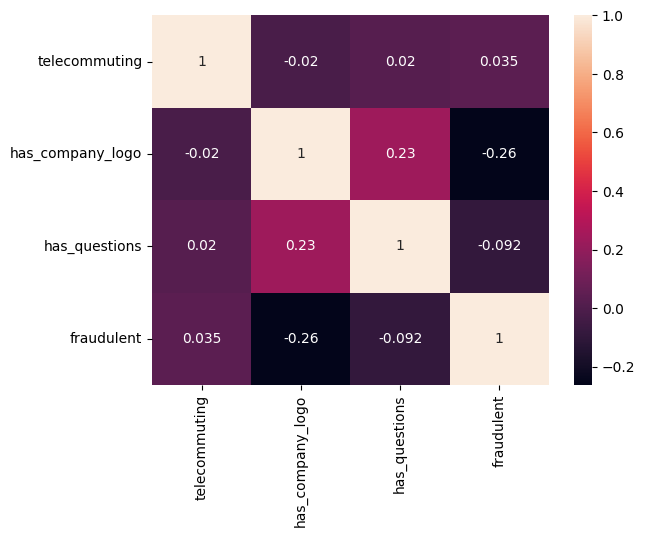

In [28]:
sb.heatmap(df[["telecommuting","has_company_logo","has_questions","fraudulent"]].corr(),annot=True);

In [29]:
df.fillna(" ", inplace = True)

In [30]:
df['text'] = df['title'] + " " + df['department'] + \
             " " + df['company_profile'] + " " + \
             df['description'] + " " + \
             df['requirements'] + " " +\
             df['benefits'] + " " +\
             df['function'] + " " +\
             df['required_experience']+ " "+\
             df["required_education"]+ " " +\
             df["industry"]

In [31]:
df['text'].head()

0    Marketing Intern Marketing We're Food52, and w...
1    Customer Service - Cloud Video Production Succ...
2    Commissioning Machinery Assistant (CMA)   Valo...
3    Account Executive - Washington DC Sales Our pa...
4    Bill Review Manager   SpotSource Solutions LLC...
Name: text, dtype: object

In [32]:
df_last = df.drop(columns = ['job_id','title','location','department', 'telecommuting',
                             'salary_range','company_profile','description','requirements','benefits','employment_type',
                             'required_experience','required_education','industry','function'])
print(df_last.isna().sum())
df_last.head()

has_company_logo    0
has_questions       0
fraudulent          0
text                0
dtype: int64


,has_company_logo,has_questions,fraudulent,text
0,1,0,0,"Marketing Intern Marketing We're Food52, and w..."
1,1,0,0,Customer Service - Cloud Video Production Succ...
2,1,0,0,Commissioning Machinery Assistant (CMA) Valo...
3,1,0,0,Account Executive - Washington DC Sales Our pa...
4,1,1,0,Bill Review Manager SpotSource Solutions LLC...


In [33]:
#JUST FOR TESTING
first_description = df.description[3]
description = re.sub("[^a-zA-Z]", " ", first_description)
description = description.upper()   
description

'THE COMPANY  ESRI   ENVIRONMENTAL SYSTEMS RESEARCH INSTITUTEOUR PASSION FOR IMPROVING QUALITY OF LIFE THROUGH GEOGRAPHY IS AT THE HEART OF EVERYTHING WE DO   ESRI S GEOGRAPHIC INFORMATION SYSTEM  GIS  TECHNOLOGY INSPIRES AND ENABLES GOVERNMENTS  UNIVERSITIES AND BUSINESSES WORLDWIDE TO SAVE MONEY  LIVES AND OUR ENVIRONMENT THROUGH A DEEPER UNDERSTANDING OF THE CHANGING WORLD AROUND THEM CAREFULLY MANAGED GROWTH AND ZERO DEBT GIVE ESRI STABILITY THAT IS UNCOMMON IN TODAY S VOLATILE BUSINESS WORLD   PRIVATELY HELD  WE OFFER EXCEPTIONAL BENEFITS  COMPETITIVE SALARIES      K  AND PROFIT SHARING PROGRAMS  OPPORTUNITIES FOR PERSONAL AND PROFESSIONAL GROWTH  AND MUCH MORE THE OPPORTUNITY  ACCOUNT EXECUTIVEAS A MEMBER OF THE SALES DIVISION  YOU WILL WORK COLLABORATIVELY WITH AN ACCOUNT TEAM IN ORDER TO SELL AND PROMOTE ADOPTION OF ESRI S ARCGIS PLATFORM WITHIN AN ORGANIZATION  AS PART OF AN ACCOUNT TEAM  YOU WILL BE RESPONSIBLE FOR FACILITATING THE DEVELOPMENT AND EXECUTION OF A SET OF STRATE

In [34]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [35]:
description = nltk.word_tokenize(description)

In [36]:
len(description)

354

In [37]:
nltk.download('stopwords')
description = [ word for word in description if not word in set(stopwords.words("english"))]
len(description)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


354

In [38]:
nltk.download('omw-1.4')
nltk.download('wordnet')
lemma = nlp.WordNetLemmatizer()
description = [lemma.lemmatize(word) for word in description]
len(description)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...


[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


354

In [39]:
text_list = []

for text in df_last.text:
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    text = text.strip()
    text = nltk.word_tokenize(text)
    text = [word for word in text if not word in set(stopwords.words("english"))] 
    lemma = nlp.WordNetLemmatizer()
    text = [lemma.lemmatize(word) for word in text]
    text = " ".join(text)
    text = text.replace('  ',' ')
    text_list.append(text)

In [40]:
len(text_list)

17880

In [41]:
df_last.fraudulent.value_counts(dropna = False)

fraudulent
0    17014
1      866
Name: count, dtype: int64

In [42]:
df1 = pd.DataFrame()
df1['text'] = text_list
df1['freu'] = df_last.fraudulent

In [43]:
df1['text'][0]

'marketing intern marketing food created groundbreaking award winning cooking site support connect celebrate home cook give everything need one place top editorial business engineering team focused using technology find new better way connect people around specific food interest offer superb highly curated information food cooking attract talented home cook contributor country also publish well known professional like mario batali gwyneth paltrow danny meyer partnership whole food market random house food named best food website james beard foundation iacp featured new york time npr pando daily techcrunch today show located chelsea new york city food fast growing james beard award winning online food community crowd sourced curated recipe hub currently interviewing full part time unpaid intern work small team editor executive developer new york city headquarters reproducing repackaging existing food content number partner site huffington post yahoo buzzfeed various content management s

In [44]:
df1['word count'] = [len(i.split(' ')) for i in df1['text']]

In [45]:
df1.head()

,text,freu,word count
0,marketing intern marketing food created ground...,0,256
1,customer service cloud video production succes...,0,614
2,commissioning machinery assistant cma valor se...,0,236
3,account executive washington dc sale passion i...,0,495
4,bill review manager spotsource solution llc gl...,0,381


In [46]:
sent_length = df1['word count'].max()

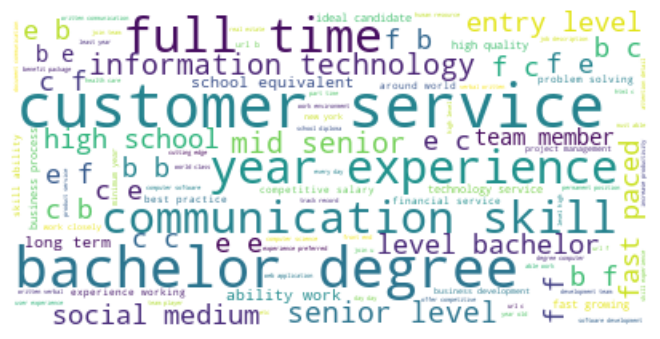

In [47]:
text = " ".join(i for i in df1['text'])
wordcloud = WordCloud(background_color = "white", max_words = 500).generate(text)
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [48]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df1['text'], 25)

In [49]:
df2 = pd.DataFrame(common_words, columns=['word', 'transition frequency'])
fig = px.bar(df2, x='word', y='transition frequency',
             hover_data=['word', 'transition frequency'], color='transition frequency',
             title='Top 25 most common words',
             height=400,
             text_auto='.3s')
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
# fig.bar_label(fig.containers[0], fmt='%g', label_type='edge', labels=df1['transition frequency'])
fig.show()


In [50]:
max_features = 10000

t = Tokenizer(num_words = max_features)
t.fit_on_texts(text_list)
encoded_docs = t.texts_to_sequences(text_list)

In [51]:
joblib.dump(t, './tokinezer_file')

['./tokinezer_file']

In [52]:
embedded_docs=pad_sequences(encoded_docs,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ...  132   26  667]
 [   0    0    0 ...  580   26  280]
 [   0    0    0 ...  568   24 1515]
 ...
 [   0    0    0 ...   10  646   11]
 [   0    0    0 ...   57  869   28]
 [   0    0    0 ...   27  122   36]]


In [53]:
y = df1['freu'].values
print(y)

y = y.reshape(-1,1)
print (y.shape)

X = np.array(embedded_docs)
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.1, random_state= 101)

print("X_train shape: ",X_train.shape)
print("X_test shape : ",X_test.shape )
print("y_train shape: ",y_train.shape)
print("y_test shape : ",y_test.shape)

[0 0 0 ... 0 0 0]
(17880, 1)
(17880, 1426)
X_train shape:  (16092, 1426)
X_test shape :  (1788, 1426)
y_train shape:  (16092, 1)
y_test shape :  (1788, 1)


In [54]:
# The model cannot operate text data so we need to convert our data into vector format
# we will be using Bag of words model 
from sklearn.feature_extraction.text import CountVectorizer

#  instantiate the vectorizer
vect = CountVectorizer()

# learn training data vocabulary, then use it to create a document-term matrix
# fit
vect.fit(X_train)

# transform training data
X_train_dtm = vect.transform(X_train)


AttributeError: 'numpy.ndarray' object has no attribute 'lower'

In [55]:
def eval_metrics(actual, prediction):
    print("Accuracy Score: {}".format(accuracy_score(actual, prediction)))
    print("Recall Score: {}".format(recall_score(actual, prediction)))
    print("f1 Score: {}".format(f1_score(actual, prediction)))
    print("Precision Score: {}".format(precision_score(actual, prediction)))

In [72]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') >= 0.9999 and logs.get('val_accuracy') >= 0.9800):
            self.model.stop_training = True

CALLBACK = myCallback()

In [73]:
embedding_vector_features=40

model1 = Sequential([
    tf.keras.layers.Embedding(input_dim=max_features, output_dim=embedding_vector_features, input_length=sent_length),
    tf.keras.layers.Bidirectional(LSTM(20)),
    tf.keras.layers.Dense(1, activation='sigmoid') # softmax karena berdasarkan probabilitas, membandingkan dua buah peluang mana yang bagus dengan output 2
])
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

print(model1.summary())

model1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1426, 40)          400000    
                                                                 
 bidirectional_4 (Bidirecti  (None, 40)                9760      
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 1)                 41        
                                                                 
Total params: 409801 (1.56 MB)
Trainable params: 409801 (1.56 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [75]:
# cp = ModelCheckpoint("./job_model/" ,save_best_only = True)
hist = model1.fit(X_train, y_train, epochs = 40, batch_size = 64,  callbacks=[CALLBACK] , validation_data=(X_test,y_test))

Epoch 1/40
252/252 [==============================] - 167s 662ms/step - loss: 0.1767 - accuracy: 0.9538 - val_loss: 0.1160 - val_accuracy: 0.9676
Epoch 2/40
252/252 [==============================] - 164s 649ms/step - loss: 0.0817 - accuracy: 0.9769 - val_loss: 0.0860 - val_accuracy: 0.9765
Epoch 3/40
252/252 [==============================] - 164s 651ms/step - loss: 0.0545 - accuracy: 0.9855 - val_loss: 0.0796 - val_accuracy: 0.9771
Epoch 4/40
252/252 [==============================] - 169s 671ms/step - loss: 0.0384 - accuracy: 0.9894 - val_loss: 0.0749 - val_accuracy: 0.9804
Epoch 5/40
252/252 [==============================] - 171s 677ms/step - loss: 0.0282 - accuracy: 0.9925 - val_loss: 0.0811 - val_accuracy: 0.9810
Epoch 6/40
252/252 [==============================] - 166s 659ms/step - loss: 0.0165 - accuracy: 0.9963 - val_loss: 0.0823 - val_accuracy: 0.9810
Epoch 7/40
252/252 [==============================] - 167s 662ms/step - loss: 0.0116 - accuracy: 0.9971 - val_loss: 0.0856 -

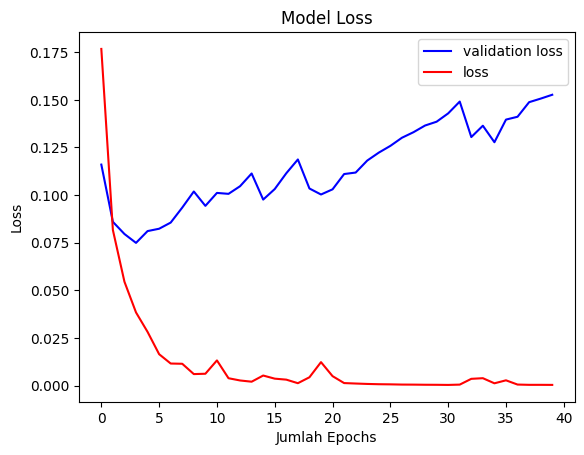

In [77]:
plt.plot(hist.history['val_loss'], color='b', label="validation loss")
plt.plot(hist.history['loss'], color='red', label="loss")
plt.title("Model Loss")
plt.xlabel("Jumlah Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

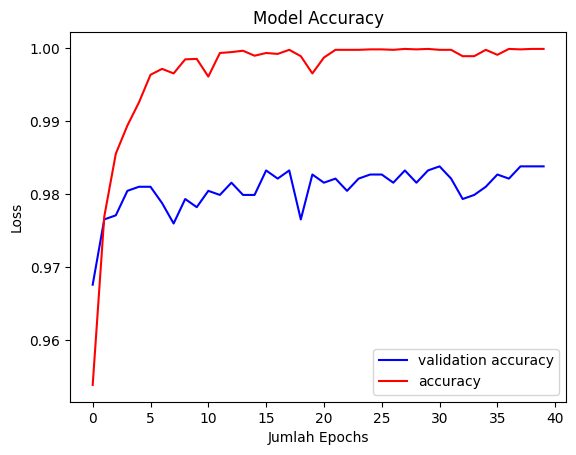

In [78]:
plt.plot(hist.history['val_accuracy'], color='b', label="validation accuracy")
plt.plot(hist.history['accuracy'], color='red', label="accuracy")
plt.title("Model Accuracy")
plt.xlabel("Jumlah Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


503/503 [==============================] - 64s 127ms/step
=====Classification Report=====
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1704
           1       0.92      0.71      0.81        84

    accuracy                           0.98      1788
   macro avg       0.95      0.86      0.90      1788
weighted avg       0.98      0.98      0.98      1788

=====kinerja model saat diuji pada data yang tidak pernah dilihat sebelumnya=====
Accuracy Score: 0.9837807606263982
Recall Score: 0.7142857142857143
f1 Score: 0.8053691275167787
Precision Score: 0.9230769230769231
=====kinerja model saat diuji pada data yang telah dilatih=====
Accuracy Score: 0.9998757146408153
Recall Score: 0.9974424552429667
f1 Score: 0.998719590268886
Precision Score: 1.0
=====Confussion Matrix=====


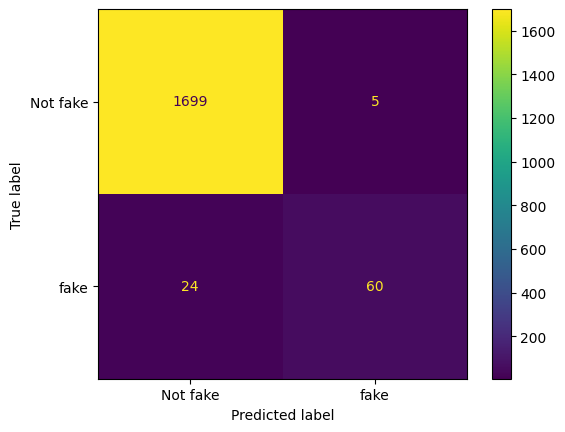

In [79]:
model = load_model("model_JobDetection_new.h5")
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
y_train_pred = model.predict(X_train)
y_train_pred = (y_train_pred > 0.5)
cnf=confusion_matrix(y_test, y_pred)
ax= ConfusionMatrixDisplay(cnf,display_labels=['Not fake','fake']).plot()
print("=====Classification Report=====")
print(classification_report(y_test, y_pred))
print("=====kinerja model saat diuji pada data yang tidak pernah dilihat sebelumnya=====")
eval_metrics(y_test, y_pred)
print("=====kinerja model saat diuji pada data yang telah dilatih=====")
eval_metrics(y_train, y_train_pred)
print("=====Confussion Matrix=====")


In [ ]:
input_text=["customer service associate us, ca, san francisco novitex enterprise solutions, formerly pitney bowes management services, delivers innovative document communications management solutions help companies around world drive business process efficiencies, increase productivity, reduce costs improve customer satisfaction. almost 30 years, clients turned us integrate optimize enterprise-wide business processes empower employees, increase productivity maximize results. trusted partner, continually focus delivering secure, technology-enabled document communications solutions improve clients' work processes, enhance customer interactions drive growth. customer service associate based san francisco, ca. right candidate integral part talented team, supporting continued growth.responsibilities:perform various mail center activities (sorting, metering, folding, inserting, delivery, pickup, etc.)lift heavy boxes, files paper neededmaintain highest levels customer care demonstrating friendly cooperative attitudedemonstrate flexibility satisfying customer demands high volume, production environmentconsistently adhere business procedure guidelinesadhere safety procedurestake direction supervisor site managermaintain logs reporting documentation; attention detailparticipate cross-training perform duties assigned (filing, outgoing shipments, etc)operating mailing, copy scanning equipmentshipping & receivinghandle time-sensitive material like confidential, urgent packagesperform tasks assignedscanning incoming mail recipientsperform file purges pullscreate files ship filesprovide backfill neededenter information daily spreadsheetsidentify charges match billingsort deliver mail, small packages minimum requirements:minimum 6 months customer service related experience requiredhigh school diploma equivalent (ged) requiredpreferred qualifications:keyboarding windows environment pc skills required (word, excel powerpoint preferred)experience running mail posting equipment plusexcellent communication skills verbal writtenlifting 55 lbs without accommodationswillingness availability work additional hours assignedwillingness submit pre-employment drug screening criminal background checkability effectively work individually team environmentcompetency performing multiple functional tasksability meet employer's attendance policy computer software"]

In [ ]:
  
# convert text to feature vectors
input_data_features = vect.transform(input_text)

# making prediction

prediction = predict(input_data_features)
print(prediction)


if (prediction[0]==1):
  print('Fraudulant Job')

else:
  print('Real Job')

In [ ]:
tf.keras.saving.save_model(
    model, filepath, overwrite=True, save_format='h5', **kwargs
)

In [76]:
if __name__ == '__main__':
    # DO NOT CHANGE THIS CODE
    model1.save("model_JobDetection_new.h5")

    # tfjs.converters.save_keras_model(model, 'tfjs_model')

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [2]:
#Lets Predict for a data set
X_test

NameError: name 'X_test' is not defined

In [3]:
print(X_test[972])

NameError: name 'X_test' is not defined

In [4]:
input_text=["customer service associate us, ca, san francisco novitex enterprise solutions, formerly pitney bowes management services, delivers innovative document communications management solutions help companies around world drive business process efficiencies, increase productivity, reduce costs improve customer satisfaction. almost 30 years, clients turned us integrate optimize enterprise-wide business processes empower employees, increase productivity maximize results. trusted partner, continually focus delivering secure, technology-enabled document communications solutions improve clients' work processes, enhance customer interactions drive growth. customer service associate based san francisco, ca. right candidate integral part talented team, supporting continued growth.responsibilities:perform various mail center activities (sorting, metering, folding, inserting, delivery, pickup, etc.)lift heavy boxes, files paper neededmaintain highest levels customer care demonstrating friendly cooperative attitudedemonstrate flexibility satisfying customer demands high volume, production environmentconsistently adhere business procedure guidelinesadhere safety procedurestake direction supervisor site managermaintain logs reporting documentation; attention detailparticipate cross-training perform duties assigned (filing, outgoing shipments, etc)operating mailing, copy scanning equipmentshipping &amp; receivinghandle time-sensitive material like confidential, urgent packagesperform tasks assignedscanning incoming mail recipientsperform file purges pullscreate files ship filesprovide backfill neededenter information daily spreadsheetsidentify charges match billingsort deliver mail, small packages minimum requirements:minimum 6 months customer service related experience requiredhigh school diploma equivalent (ged) requiredpreferred qualifications:keyboarding windows environment pc skills required (word, excel powerpoint preferred)experience running mail posting equipment plusexcellent communication skills verbal writtenlifting 55 lbs without accommodationswillingness availability work additional hours assignedwillingness submit pre-employment drug screening criminal background checkability effectively work individually team environmentcompetency performing multiple functional tasksability meet employer's attendance policy computer software"]

In [ ]:
vect = CountVectorizer()

vect.fit(X_train)

# transform training data
X_train_dtm = vect.transform(X_train)

AttributeError: 'numpy.ndarray' object has no attribute 'lower'

In [ ]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

NotFittedError: Vocabulary not fitted or provided

In [5]:
# convert text to feature vectors
input_data_features = vect.transform(input_text)

# making prediction

prediction = dt.predict(input_data_features)
print(prediction)


if (prediction[0]==1):
  print('Fraudulant Job')

else:
  print('Real Job')

NameError: name 'vect' is not defined

In [ ]:
model = load_model("./job_model/")

Training Data:
                                  text  label
4  Neural networks are powerful tools.      1
2         Data science is fascinating.      1
0             I love machine learning!      1
3           I dislike bugs in my code.      0

Test Data:
                                          text  label
1  Python is a versatile programming language.      1


NotFittedError: Vocabulary not fitted or provided